# Игры - Анализ рекламных источников.

# Материалы.
* Дашборд. (https://public.tableau.com/views/Book2_16527996453710/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link)

<b>Задача: анализ поведения игроков в зависимости от источника перехода.</b>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
from scipy import stats as st

## Предобработка данных.

Предобработка будет выполнена за несколько шагов:
- Исследовать пропущенные значения;
- Исследовать соответствие типов;
- Исследовать дубликаты;
- Проверить корректность наименований колонок;
- Переименовать колонки;
- Удалить дубликаты;
- Привести типы;
- Заменить пропущенные значения.

In [2]:
game_actions = pd.read_csv('/datasets/game_actions.csv')
ad_costs = pd.read_csv('/datasets/ad_costs.csv')
user_source = pd.read_csv('/datasets/user_source.csv')

Описание датасетов:

Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Датасет *game_actions.csv*:

- `event_datetime` — время события;


- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;


- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;


- `user_id` — идентификатор пользователя;


- `project_type` — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.

Датасет *ad_cost.csv*:

- `day` - день, в который был совершен клик по объявлению


- `source` - источник трафика


- `cost` - стоимость кликов

Датасет user_source.csv содержит колонки:

- `user_id` - идентификатор пользователя


- `source` - источников, с которого пришёл пользователь, установивший приложение

In [3]:
def info(data):
    """"
    Функция для вывода первых 5 строк, краткой информации и статистики по таблицам данных.
    """    
    print('\033[1m' + 'Информация, включающая записи датасета:' + '\033[0m')
    display(data.head())
    print(60*'*')
    print('\033[1m' + 'Общая информация датасета:' + '\033[0m')
    data.info()
    print(60*'*')
    print('\033[1m' + 'Статистика датасета:' + '\033[0m')
    display(data.describe())
    print(60*'*')
    print('\033[1m' + 'Информация, включающая пропуски датасета:' + '\033[0m')
    display(pd.concat([data.isna().sum(), data.isna().mean()], axis=1)\
    .rename(columns={0:'кол-во', 1:'доля'})\
    .style.format({'кол-во':'{:.0f}', 'доля':'{:.2%}'}))

In [4]:
info(game_actions)

Информация, включающая записи датасета:


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


************************************************************
Общая информация датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB
************************************************************
Статистика датасета:


,event_datetime,event,building_type,user_id,project_type
count,135640,135640,127957,135640,1866
unique,128790,3,3,13576,1
top,2020-05-09 12:35:56,building,spaceport,bf542075-e3a2-4e79-82d8-3838e86d2a25,satellite_orbital_assembly
freq,4,127957,59325,22,1866


************************************************************
Информация, включающая пропуски датасета:


,кол-во,доля
event_datetime,0,0.00%
event,0,0.00%
building_type,7683,5.66%
user_id,0,0.00%
project_type,133774,98.62%


* В данном датасете 5 столбцов, в двух из них присутствуют пропуски - `building_type`, и `project_type`. 
* В столбце `building_type` храниться информация о типах построек, а в столбце 'project_type' информация о типе реализованного объекта. 
* Уровень в нашей игре можно пройти двумя способами: победить первого врага или реализовать проект-разработка орбитальной сборки спутников. Из этого следует, что не все игроки пройдут уровень через реализацию проекта, а значит у них будет пропуск в столбце `project_type`. 
* Так же возможно для реализации проекта нет необходимости строить здания, а можно сразу завершить проект и пройти уровень, поэтому у таких игроков могут быть пропуски. 
* Нельзя исключать и то, что не все игроки завершили уровень и просто покинули игру, ничего не сделав, у них тоже могут быть пропуски. 
* Пропуски можно заполнить значением по умолчанию, что бы было проще проводить обработку данных.
* Названия столбцов приведены к правильному виду. 
* У столбца `event_datetime` необходимо изменить тип с `object` на `datetime`.

In [5]:
game_actions = game_actions.fillna('unknown') # Заполнение пропусков значением по умолчанию.

In [6]:
# Преобразование типа данных.
game_actions['event_datetime'] = pd.to_datetime(
                                        game_actions['event_datetime'], 
                                            format='%Y-%m-%dT%H:%M:%S'
                                                )

Проверка преобразования типа данных в столбце.

In [7]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135640 non-null  datetime64[ns]
 1   event           135640 non-null  object        
 2   building_type   135640 non-null  object        
 3   user_id         135640 non-null  object        
 4   project_type    135640 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB


Теперь все столбцы имеют верные типы данных.

In [8]:
info(ad_costs)

Информация, включающая записи датасета:


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


************************************************************
Общая информация датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
************************************************************
Статистика датасета:


,cost
count,28.000000
mean,271.556321
std,286.867650
min,23.314669
25%,66.747365
50%,160.056443
75%,349.034473
max,969.139394


************************************************************
Информация, включающая пропуски датасета:


,кол-во,доля
source,0,0.00%
day,0,0.00%
cost,0,0.00%


В данном датасете три стобца, пропусков нет, названия приведены к правильному виду. Столбец 'day' имеет тип данных object, его необходимо сменить на datetime. Так как среднее значение больше медианного, значит набор данных имеет скошенность в положительную сторону.

In [9]:
ad_costs['day'] = pd.to_datetime(ad_costs['day'], format='%Y-%m-%dT') # Преобразование типа данных.

Проверка преобразования типа данных в столбце.

In [10]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


Теперь все столбцы имеют верные типы данных.

In [11]:
info(user_source)

Информация, включающая записи датасета:


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


************************************************************
Общая информация датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB
************************************************************
Статистика датасета:


,user_id,source
count,13576,13576
unique,13576,4
top,7e59d584-eb5e-44af-bb9e-58dc24128479,yandex_direct
freq,1,4817


************************************************************
Информация, включающая пропуски датасета:


,кол-во,доля
user_id,0,0.00%
source,0,0.00%


Проверка на наличие явных дубликатов.

In [12]:
game_actions.duplicated().sum()

1

Всего нашёлся один явный дубликат, его можно удалить, так как он не повлияет на дальнейшее исследование.

In [13]:
game_actions = game_actions.drop_duplicates().reset_index(drop=True)
game_actions.duplicated().sum()

0

In [14]:
ad_costs.duplicated().sum()

0

In [15]:
user_source.duplicated().sum()

0

В остальных датасетах дубликатов нет.

## Исследовательский анализ данных.

Исследовательский анализ данных выполним следующим образом:
- Определить данными за какой период мы обладаем.
- Исследовать распределение данных в каждом датасете.
- Исследовать выбросы и обработать их.
- Определить источники из которых пришли пользователи.
- Из какого источника пришло больше пользователей.
- Построить профили пользователей.
- Какие пользователи построили больше зданий.
- Какие пользователи закончили уровень реализацией проекта.

### Определение периода.

Определим за какой временной промежуток собраны данные в датасетах. В датасете user_source нет столбца с датами.

In [16]:
print(game_actions['event_datetime'].min())
print(game_actions['event_datetime'].max())

2020-05-04 00:00:01
2020-06-05 12:32:49


В датасете game_actions собраны данные за период с 2020-05-04 по 2020-06-05.

In [17]:
print(ad_costs['day'].min())
print(ad_costs['day'].max())

2020-05-03 00:00:00
2020-05-09 00:00:00


В датасете ad_costs собранны данные за период с 2020-05-03 по 2020-05-09

### Распределение данных в датасетах.

Теперь необходимо рассмотреть как распределены данные в датасетах.

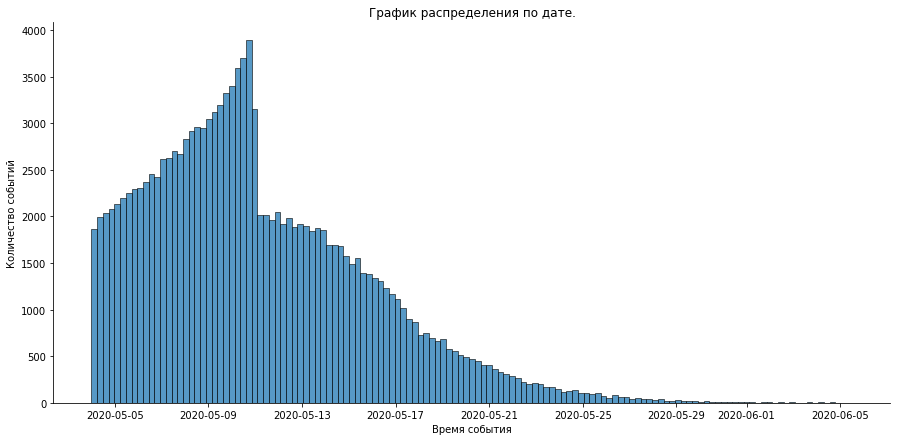

In [18]:
plt.figure(figsize=(15, 7))
ax = sns.histplot(game_actions['event_datetime'])
ax.set_title('График распределения по дате.')
ax.set_xlabel('Время события')
ax.set_ylabel('Количество событий')
sns.despine()

* Данные распределены не нормально, начиная с 4 мая идёт нарастание количества событий вплоть до 11 мая, затем происходит резкий спад в два раза (с 4000 до 2000). 
* Такое поведение графика можно объяснить тем, что в этот период были праздничные дни, проходила рекламная кампания (в датасете ad_costs данные за период с 3 мая по 9 мая), поэтому шёл рост количества пользователей и количества их действий. Либо в данных присутсвует ошибка, вносящая такое искажение.

Построим графики распределения по типу события для пользователей.

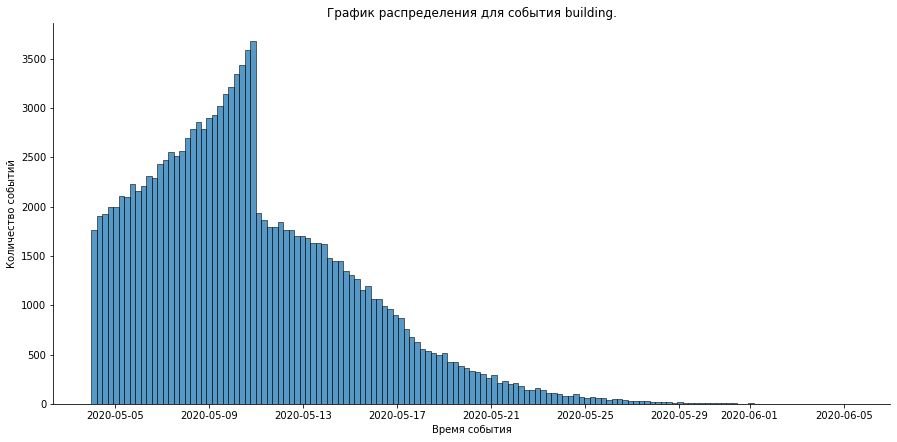

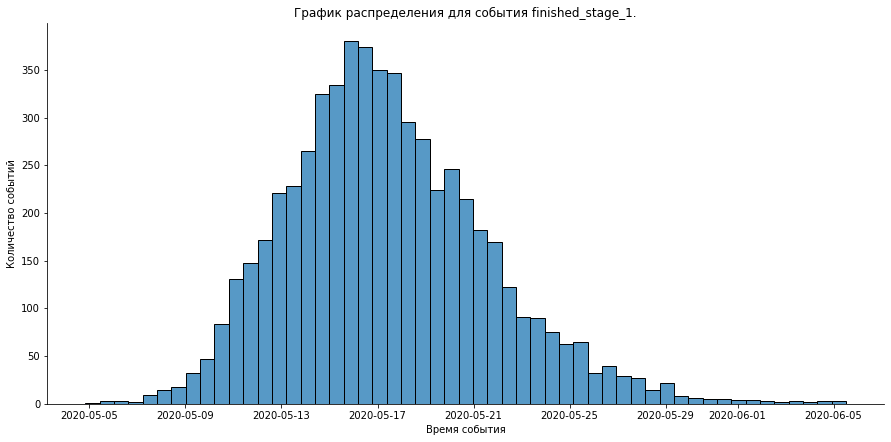

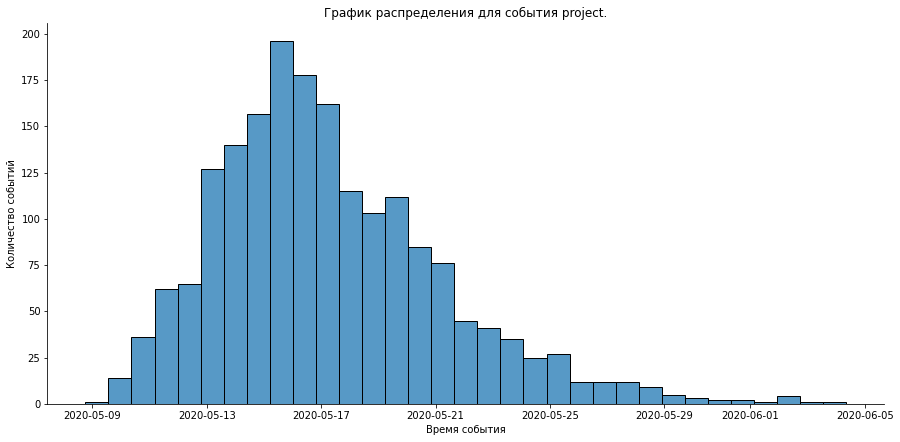

In [19]:
# Цикл для построения графиков распределения.
for event, data in game_actions.groupby('event'):
    data = game_actions[game_actions['event']==event]
    plt.figure(figsize=(15, 7))
    ax = sns.histplot(data['event_datetime'])
    ax.set_title('График распределения для события {}.'.format(event))
    ax.set_xlabel('Время события')
    ax.set_ylabel('Количество событий')
    sns.despine()

Из полученных графиков видно, что основную часть аномалии графика составляет событие 'building'. Возможно проведилась акция на постройку зданий в игре.

Рассмотрим какие действия делали игроки чаще. Построим график распределения по столбцу 'event'.

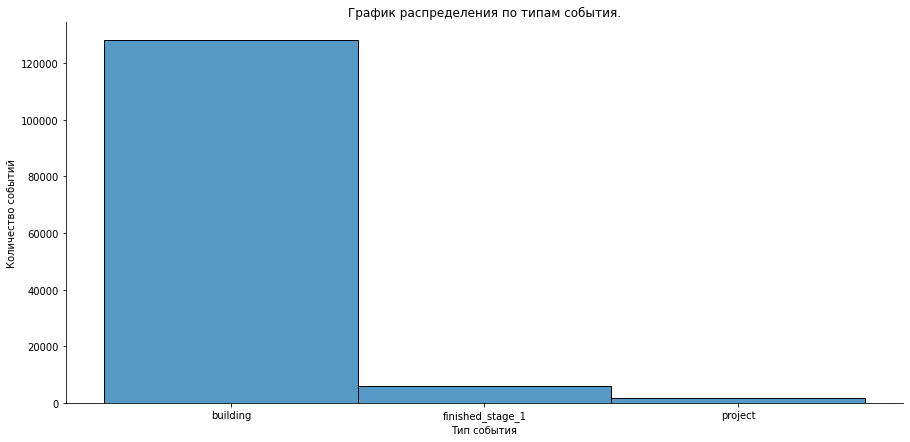

In [20]:
plt.figure(figsize=(15, 7))
ax = sns.histplot(game_actions['event'])
ax.set_title('График распределения по типам события.')
ax.set_xlabel('Тип события')
ax.set_ylabel('Количество событий')
sns.despine()

График показал, что игроки в основном занимались постройками зданий.

Построим как распределено количество кликов по баннерам для разных каналов.

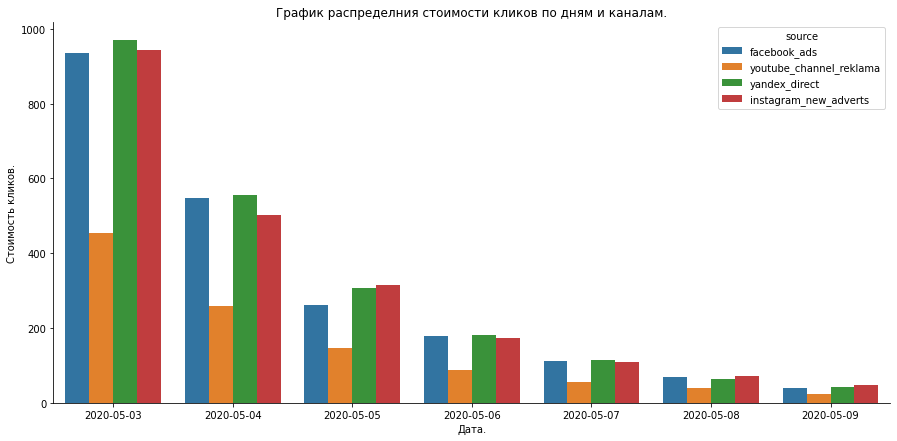

In [21]:
sort = ad_costs.sort_values(by=['day'])
sort['day'] = sort['day'].dt.date
plt.figure(figsize=(15, 7))
ax = sns.barplot(x='day', y='cost', hue='source', data=sort)
ax.set_title('График распределния стоимости кликов по дням и каналам.')
ax.set_xlabel('Дата.')
ax.set_ylabel('Стоимость кликов.')
sns.despine()

* Стоимость кликов для всех каналов уменьшается с каждым днём. 
* Наименьшая стоимость кликов у канала `youtube`, у остальных каналов она примерно одинаковая, и резко падает.
* Стоимость кликов для каналов быстро снижается с каждым днём, но для `youtube` снижение происходит медленее. Тем не менее стоимость кликов для этого канала остаётся самой низкой даже в последний день рекламной кампании.

Теперь рассмотрим как распределены пользователи по каналам.

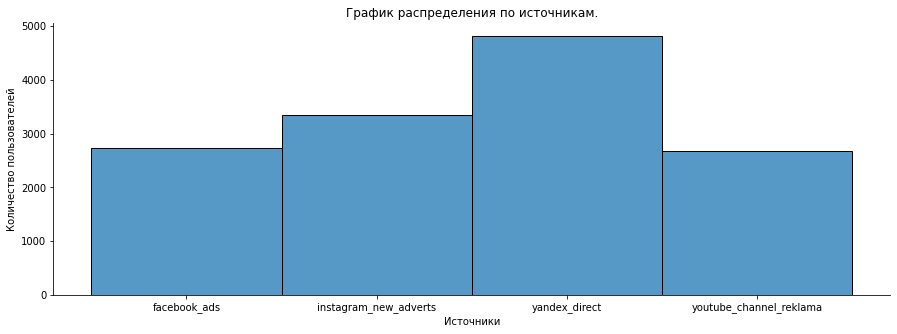

In [22]:
sort = user_source.sort_values(by='source')
plt.figure(figsize=(15, 5))
ax = sns.histplot(sort['source'])
ax.set_title('График распределения по источникам.')
ax.set_xlabel('Источники')
ax.set_ylabel('Количество пользователей')
sns.despine()

In [23]:
user_source.sort_values(by='source').groupby('source').agg({'user_id': 'count'})

,user_id
source,
facebook_ads,2726
instagram_new_adverts,3347
yandex_direct,4817
youtube_channel_reklama,2686


Пользователи пришли из 4 источников. Наибольшее количество пользователей пришло из канала yandex_direct.

### Профили и стоимость привлечения.

In [24]:
# Построение профилей пользователей.
profiles = game_actions.merge(user_source, on='user_id', how='left')
profiles['day'] = profiles['event_datetime'].dt.date
profiles.head()

,event_datetime,event,building_type,user_id,project_type,source,day
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,unknown,youtube_channel_reklama,2020-05-04
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,unknown,facebook_ads,2020-05-04
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,unknown,instagram_new_adverts,2020-05-04
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,unknown,facebook_ads,2020-05-04
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,unknown,yandex_direct,2020-05-04


In [25]:
# Считаем количество уникальных пользователей с одинаковыми источником.
new_users = (profiles.groupby('source')
                    .agg({'user_id': 'nunique'})
                    .rename(columns={'user_id': 'unique_users'})
                    .reset_index())

# Объединяем траты на рекламу и число привлечённых пользователей.
costs = ad_costs.merge(new_users, on=['source'], how='left')
# Делим рекламные расходы на число привлечённых пользователей.
costs['acquisition_cost'] = costs['cost'] / costs['unique_users']
costs.groupby('source').agg({'acquisition_cost': 'mean'})

,acquisition_cost
source,
facebook_ads,0.112195
instagram_new_adverts,0.092255
yandex_direct,0.066227
youtube_channel_reklama,0.056809


### Поведение пользователей.

In [26]:
def get_filtered(data, column, value):
    """
    Функция возвращает фильтр по заданным параметрам.
    """
    filtered = data[data[column]==value]
    return filtered

In [27]:
def get_grouped(data, column, func, dimensions=[]):
    """
    Функция группировки по заданным параметрам.
    """
    result = data.groupby(dimensions).agg({column: func})
    return result

In [28]:
filtered = get_filtered(profiles, 'event', 'building')

In [29]:
result = get_grouped(filtered, 'user_id', 'count', dimensions=['source'])
result['ratio'] = round(result/(profiles.groupby('source').agg({'user_id': 'nunique'})),3)
result

,user_id,ratio
source,,
facebook_ads,26131,9.586
instagram_new_adverts,31815,9.506
yandex_direct,45032,9.349
youtube_channel_reklama,24978,9.299


Количество построек на одного пользователя примерно одинаково для всех каналов. Для `facebook` и `instgram`, этот показатель немного выше, чем для `yandex` и `youtube`.

In [30]:
profiles['project_type'].unique() # Определение уникальных значений.

array(['unknown', 'satellite_orbital_assembly'], dtype=object)

In [31]:
filtered = get_filtered(profiles, 'project_type', 'satellite_orbital_assembly')

In [32]:
result = get_grouped(filtered, 'user_id', 'nunique', dimensions=['source'])
result['ratio'] = round(result/(profiles.groupby('source').agg({'user_id': 'nunique'})),3)
result

,user_id,ratio
source,,
facebook_ads,391,0.143
instagram_new_adverts,476,0.142
yandex_direct,620,0.129
youtube_channel_reklama,379,0.141


* Наибольшее количество игроков, закончивших уровень реализацией проекта, пришли из `yandex_direct`. Наименьшее количество таких игроков пришло из `youtube` и `facebook`.
* Однако доля игроков, закончивших уровень реализацией проекта, для канала `yandex`наименьшая и составляет 13% от общего количества игроков, пришедших в игру через этот канал. 
* Для остальных каналов эта доля составляет 14%.

## Поведение игроков и гипотезы.

- Посчитать процент удержания для каждого рекламного канала.
- Определить зависисмость между каналом привличения пользователя и его поведением в игре:
    - сколько построил зданий,
    - каким способом завершил уровень,
    - как быстро завершил уровень.
- Проверить гипотезу: время завершения уровня различается в зависимости от способа прохождения:
    - через реализацию проекта,
    - через победу над первым игроком.
- Проверить гипотезу: среднее количество построенных зданий различается в зависимости от способа прохождения:
    - через реализацию проекта,
    - через победу над первым игроком.

### Поведение игроков.

In [33]:
filtered = get_filtered(profiles, 'event', 'finished_stage_1')

In [34]:
result = get_grouped(filtered, 'user_id', 'nunique', dimensions=['source'])
result['ratio'] = round(result/(profiles.groupby('source').agg({'user_id': 'nunique'})),3)
result

,user_id,ratio
source,,
facebook_ads,1150,0.422
instagram_new_adverts,1466,0.438
yandex_direct,2042,0.424
youtube_channel_reklama,1159,0.431


Наибольший процент удержания игроков, пришедших с каналов 'instagram' и 'youtube'. У остальных каналов процент удержания немнго меньше. В целом по всем каналам процент удержания не превышает 45.

In [35]:
filtered = get_filtered(profiles, 'event', 'building')

In [36]:
result = get_grouped(filtered, 'user_id', 'count', dimensions=['source'])
result['ratio'] = round(result/(profiles.groupby('source').agg({'user_id': 'nunique'})),3)
result

,user_id,ratio
source,,
facebook_ads,26131,9.586
instagram_new_adverts,31815,9.506
yandex_direct,45032,9.349
youtube_channel_reklama,24978,9.299


* Игроки пришедшие из канала `yandex_direct`, строят больше всех зданий. Наименьшее количество построенных зданий у игроков, пришедших из `youtube`. 
* Количество построек на одного пользователя примерно одинаково для всех каналов. Для `facebook` и `instgram`, этот показатель немного выше, чем для `yandex` и `youtube`.

Далее определим каким способом игроки чаще завершали уровень и для какого канала есть характерные особенности.

In [37]:
def get_users_filtered(data, column, func, dimensions=[], ignore_check=False):
    """
    Функция возвращает отфильтрованный датасет по заданным параметрам с проверкой на совпадение user_id по двум критериям.
    """
    result = (data[data['user_id'].isin(filtered['user_id'])]).groupby(dimensions).agg({column: func})
    if not ignore_check:
        result = (data[data['user_id'].isin(filtered['user_id'])])
        inter = np.intersect1d(result.query('event == "project"')['user_id'].unique(), 
                       result.query('event == "finished_stage_1"')['user_id'].unique())
        result = (result[~result['user_id'].isin(inter)]).groupby(dimensions).agg({column: func})
    return result

In [38]:
filtered = get_filtered(profiles, 'event', 'finished_stage_1')
result = get_users_filtered(profiles, 'user_id', 'nunique', dimensions=['source'])
result['ratio'] = round(result/(profiles.groupby('source').agg({'user_id': 'nunique'})),3)
result

,user_id,ratio
source,,
facebook_ads,759,0.278
instagram_new_adverts,990,0.296
yandex_direct,1422,0.295
youtube_channel_reklama,780,0.290


In [39]:
filtered = get_filtered(profiles, 'project_type', 'satellite_orbital_assembly')
result = get_users_filtered(profiles, 'user_id', 'nunique', dimensions=['source'], ignore_check=True)
result['ratio'] = round(result/(profiles.groupby('source').agg({'user_id': 'nunique'})),3)
result

,user_id,ratio
source,,
facebook_ads,391,0.143
instagram_new_adverts,476,0.142
yandex_direct,620,0.129
youtube_channel_reklama,379,0.141


* Данные таблицы показывают число пользователей для каждого канала, завершивших уровень разными способами и какую часть они составляют от общего количества игроков для каждого канала. 
* Наибольшее количество игроков, закончивших уровень пришли из `yandex_direct`, наименьшее число игроков, закончивших уровень, пришли из канала `youtube` и `facebook`.

Посмотрим на среднее количество дней, потраченных на прохождение уровня для каждого канала.

In [40]:
filtered = get_filtered(profiles, 'event', 'finished_stage_1')
result = get_users_filtered(profiles, 'day', 'nunique', dimensions=['source', 'user_id'])
result = result.reset_index()

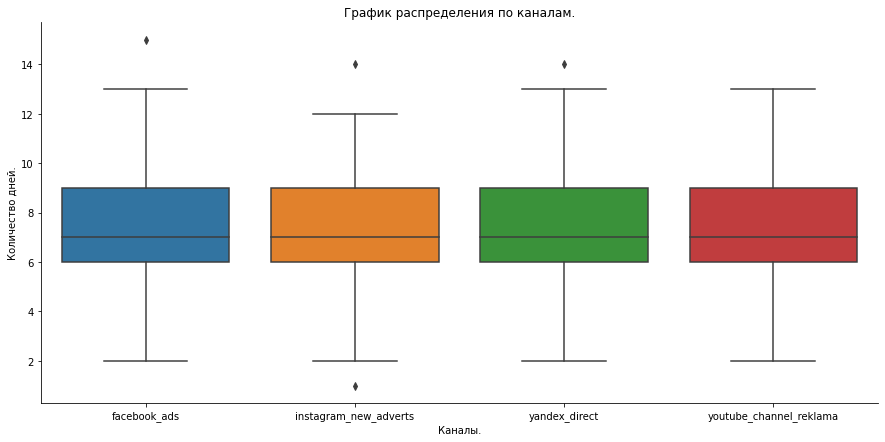

In [41]:
plt.figure(figsize=(15, 7))
ax = sns.boxplot(x='source', y='day', data=result)
ax.set_title('График распределения по каналам.')
ax.set_xlabel('Каналы.')
ax.set_ylabel('Количество дней.')
sns.despine()

Среднее количество дней, за которое игроки прошли уровень через победу над проитвником составляет от 6 до 9 дней.

In [42]:
filtered = get_filtered(profiles, 'project_type', 'satellite_orbital_assembly')
result = get_users_filtered(profiles, 'day', 'nunique', dimensions=['source', 'user_id'], ignore_check=True)
result = result.reset_index()

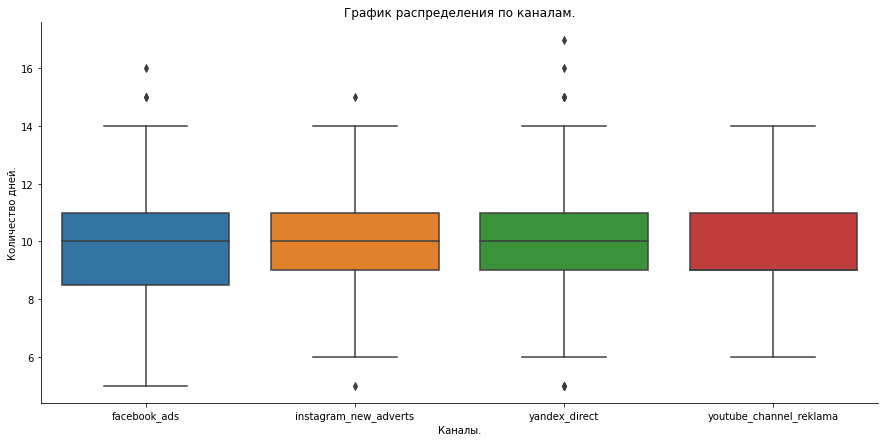

In [43]:
plt.figure(figsize=(15, 7))
ax = sns.boxplot(x='source', y='day', data=result)
ax.set_title('График распределения по каналам.')
ax.set_xlabel('Каналы.')
ax.set_ylabel('Количество дней.')
sns.despine()

Среднее количество дней, за которое игроки прошли уровень через реализацию проекта составляет 9-11 дней. Для канала 'youtube' данные имеют очень сильное положительное смещение. Медиана практически слилась с нижней границей первого квартиля.

### Гипотезы.

Проверить гипотезу: время завершения уровня различается в зависимости от способа прохождения:
 - через реализацию проекта,
 - через победу над первым игроком.

In [44]:
filtered = get_filtered(profiles, 'event', 'finished_stage_1')
win = get_users_filtered(profiles, 'day', 'nunique', dimensions=['user_id'])
win = win.reset_index()
filtered = get_filtered(profiles, 'project_type', 'satellite_orbital_assembly')
project = get_users_filtered(profiles, 'day', 'nunique', dimensions=['user_id'], ignore_check=True)
project = project.reset_index()
sample1 = project['day']
sample2 = win['day']

In [45]:
# Применение критерия Манна-Уитни.
"{0:.3f}".format(st.mannwhitneyu(sample1, sample2, False, 'two-sided')[1])

'0.000'

Статистическая значимость достигнута. Значит время заврешения уровня зависит от способа прохождения.

Рассмотрим распределение для полученных выборок, построим гистограммы.

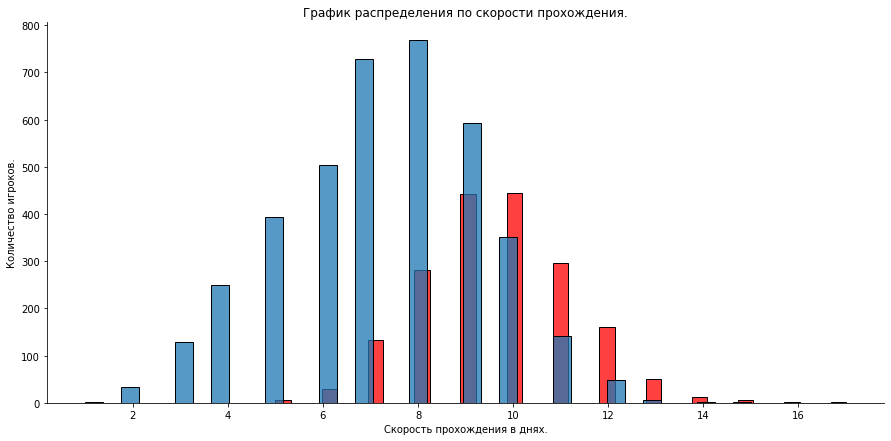

In [46]:
plt.figure(figsize=(15, 7))
ax = sns.histplot(sample1, color='red')
ax = sns.histplot(sample2)
ax.set_title('График распределения по скорости прохождения.')
ax.set_xlabel('Скорость прохождения в днях.')
ax.set_ylabel('Количество игроков.')
sns.despine()
plt.show()

По полученным графикам видно, что распределение у двух выборок отличается. 
* Игроки, завершившие уровень победой над противником, тратили на прохождение в среднем от 5 до 10 дней. 
* Игроки, завершившие уровень реализацией проекта, тратили на прохождение в среднем от 8 до 11 дней.

Проверить гипотезу: среднее количество построенных зданий различается в зависимости от способа прохождения:

- через реализацию проекта,
- через победу над первым игроком.


In [47]:
filtered = get_filtered(profiles, 'event', 'finished_stage_1')
win = get_users_filtered(profiles, 'event_datetime', 'count', dimensions=['user_id', 'event'])
win = win.reset_index()
filtered = get_filtered(profiles, 'project_type', 'satellite_orbital_assembly')
project = get_users_filtered(profiles, 'event_datetime', 'count', dimensions=['user_id', 'event'], ignore_check=True)
project = project.reset_index()
sample1 = project[project['event']=='building']['event_datetime']
sample2 = win[win['event']=='building']['event_datetime']

In [48]:
# Применение критерия Манна-Уитни.
"{0:.3f}".format(st.mannwhitneyu(sample1, sample2, False, 'two-sided')[1])

'0.000'

Статистическая значимость достигнута. Значит среднее количество построенных зданий зависит от способа прохождения.

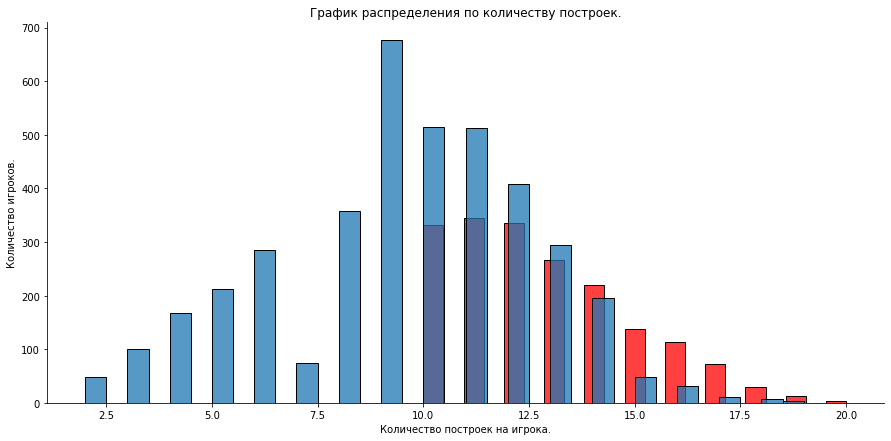

In [49]:
plt.figure(figsize=(15, 7))
ax = sns.histplot(sample1, color='red')
ax = sns.histplot(sample2)
ax.set_title('График распределения по количеству построек.')
ax.set_xlabel('Количество построек на игрока.')
ax.set_ylabel('Количество игроков.')
sns.despine()

По полученным графикам видно, что распределение у двух выборок отличается. 
* Выборка для игроков, закончивших уровень победой над противником имеет выброс около значения 9 построек на игрока.
* Игроки, завершившие уровень победой над противником, в среднем строили 8-13 построек на игрока.
* Игроки, заврешившие уровень реализацией проекта, в среднем строили 10-14 построек на игрока.

## Вывод.

Был проведён анализ рекламных источников для мобильной игры "Космические братья".

Предобработка данных позволила собрать первичную информацию и обнаружить ошибки. После чего они были исправлены, в том числе: изменён тип данных длястолбцов, хранящих информацию о датах, заполенены пропуски значением по умолчанию, обработаны дубликаты и собрана первичная статистика.

Исследовательский анализ.
* При проведении исследовательского анализа данных, был определён временной период за который собраны данные. Были изучены распределения данных в датасетах и обнаружены аномалии в данных. 
* Наибольшее количестов игроков пришло из канала `yandex_direct`, а наиболее частое действие, совершённое игроками - постройка зданий. Обнаруженая аномалия может являться следствием оишбки при заполнении таблицы или ососбенностью поведения игроков в праздничные дни с учётом проведения акций. 
* Были построены профили игроков и опредлена стоимость привлечения для каждого канала.

анализ поведения пользователей.
* Анализ поведения пользователей в зависимости от канала привлечения показал, что наибольший процент удержания игроков у каналов `instagram` и `youtube`, но в целом данный показатель для всех каналов лежит в пределах 42-43%. 
* Наибольшее количество зданий построили игроки из канала `yandex_direct`. Для этого канала также характерен наибольший процент игроков, завершивших первый уровень. 
* Количество дней, необходимое для прохождения уровня победой над противником по каждому каналу составляет 6-9 дней. А для пользователей завершивших проект и прошедших на следующий уровень этот диапозон равен 9-11 дней. 
* При проверке гипотез было обнаружено, что скорость прохождения уровня и количество построенных зданий зависит от способа прохождения. Статистическая значимость достигнута в обоих случаях.
* Распределения выборок для обоих тестов отличаются.
* По графикам можно увидеть, что игроки победившие первого противника, тратили на прохождение уровня, в среднем меньше дней, и строили,  в среднем меньше зданий.
* Игроки, реализовавшие проект, тратили на прохождение уровня, в среднем больше дней и строили, в среднем больше зданий.